# FIRE 398 Fall 2022
## Anthony Louie

# Introduction

The purpose of this notebook is to use a learning model to isolate the sky from the rest of the image. And calculate the percentage of non-sky pixels.

The learning model we are using is a classifier that seperates the image into different classes. More information about that below.

# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import urllib
import requests
import PIL
import skimage
import cv2
import colorsys
from PIL import Image
from io import BytesIO
from scipy import stats  
from skimage.color import rgb2hsv
from google.colab.patches import cv2_imshow

In [ ]:
!pip install imutils
import imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [ ]:
def input(pil_image):
  # Load and normalize one image as a singleton tensor batch
  pil_to_tensor = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
          std=[0.229, 0.224, 0.225])  # across a large photo dataset.
  ])
  # pil_image = PIL.Image.open(image_path).convert('RGB')
  img_original = imutils.resize(numpy.array(pil_image), height=450)
  pil_image_rs = Image.fromarray(img_original)
  img_data = pil_to_tensor(pil_image_rs)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]
  return img_original, pil_image_rs, img_data, singleton_batch, output_size

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

In [ ]:
def get_seg_mask(singleton_batch, output_size):
  # Run the segmentation at the highest resolution.
  with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)
      
  # Get the predicted scores for each pixel
  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()
  return pred

The pretrained model does good at finding typcial obstructions found in the GLOBE Clouds data, such as trees and buildings. But some more specific obstructions to the dataset like telephone poles, power lines, are not trained and may not be seperated from the sky portion.

# Get Obstuction Ratios From Masks

In [ ]:
def get_dilated_mask_ratio(pred):

  # get colored version of prediction
  pred_color = colorEncode(pred, colors).astype(numpy.uint8)

  #convert color prediction into NumPy array for cv2 functions
  image_cv2 = np.array(pred_color)

  # find all pixels that match the value of sky color endcoding
  sky_pixel = np.array([6, 230, 230])
  isolate_sky = cv2.inRange(image_cv2, sky_pixel, sky_pixel)
  mask = cv2.bitwise_and(image_cv2, image_cv2, mask=isolate_sky)

  # convert to binary mask with white being obstructions and black being sky
  black_pixels_mask = np.all(mask == [0, 0, 0], axis=-1)
  non_black_pixels_mask = np.any(mask != [0, 0, 0], axis=-1)
  mask[black_pixels_mask] = [255, 255, 255]
  mask[non_black_pixels_mask] = [0, 0, 0]

  # apply dilation to mask
  kernel = np.ones((2,2),np.uint8) 
  dilated_mask = cv2.dilate(mask,kernel,iterations = 8) 

  # only need one of the layers in binary mask
  dilated_mask[:,:,0]
  number_of_white_pix = np.sum(mask == 255)
  number_of_black_pix = np.sum(mask == 0)
  return (number_of_white_pix / (number_of_white_pix + number_of_black_pix))

## Load Data

In [ ]:
path = '/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/2021_GLOBE-AnnualCloudData_2022-03-24_v3-0.csv'

In [ ]:
headers = ['Observation Number','Is GLOBE Trained','is Citizen Science','Site ID','Observation Latitude','Observation Longitude','Observation Elevation','Measurement Date (UTC)','Measurement Time (UTC)','Sky Color','Sky Visibility','Total Cloud Cover','Total Cloud Cover %','Cirrus','Cirrocumulus','Cirrostratus','Altostratus','Altocumulus','Cumulus','Nimbostratus','Stratus','Stratocumulus','Cumulonimbus','Short Lived Contrails','Spreading Contrails','Non Spreading Contrails','Fog','Smoke','Haze','Volcanic Ash','Dust','Sand','Spray','Heavy Rain','Heavy Snow','Blowing Snow','Surface Snow/Ice','Surface Standing Water','Surface Muddy','Surface Dry Ground','Surface Leaves on Trees','Surface Raining or Snowing','High Cloud Cover','High Cloud Opacity','Mid Cloud Cover','Mid Cloud Opacity','Low Cloud Cover','Low Cloud Opacity','Surface Air Temperature','Surface Barometric Pressure','Surface Relative Humidity %','Ground Image North','Ground Image East','Ground Image South','Ground Image West','Ground Image Up','Ground Image Down','GEO/Terra/Aqua Satellite Match Table','CALIPSO Satellite Match Table','GEO Satellite','GEO Date','GEO Time','GEO Latitude','GEO Longitude','GEO Vzen','GEO Szen','GEO Total Cloud Cover','GEO Low Cloud Cover','GEO Mid Cloud Cover','GEO High Cloud Cover','GEO Low Liquid','GEO Mid Lquid','GEO High Liquid','GEO Low Ice','GEO Mid Ice','GEO High Ice','GEO Low Cloud Opt','GEO Mid Cloud Opt','GEO High Cloud Opt','GEO Low Cloud Temp (K)','GEO Mid Cloud Temp (K)','GEO High Cloud Temp (K)','GEO Low Cloud Altitude','GEO Mid Cloud Altitude','GEO High Cloud Altitude','GEO Snow','GEO Ocean','Terra Satellite','Terra Longitude','Terra Latitude','Terra Date','Terra Time','Terra Total Cloud Cover','Terra Low Cloud Altitude','Terra Low Cloud Opt','Terra Low Cloud Cover','Terra Low Cloud Phase','Terra Low Cloud Temp (K)','Terra Mid Cloud Altitude','Terra Mid Cloud Opt','Terra Mid Cloud Cover','Terra Mid Cloud Phase','Terra Mid Cloud Temp (K)','Terra High Cloud Altitude','Terra High Cloud Opt','Terra High Cloud Cover','Terra High Cloud Phase','Terra High Cloud Temp (K)','Terra Vzen','Terra Szen','Terra Wind','Terra Snow','Terra Ocean','Aqua Satellite','Aqua Longitude','Aqua Latitude','Aqua Date','Aqua Time','Aqua Total_Cloud_Cover','Aqua Low Cloud Altitude','Aqua Low Cloud Opt','Aqua Low Cloud Cover','Aqua Low Cloud Phase','Aqua Low Cloud Temp (K)','Aqua Mid Cloud Altitude','Aqua Mid Cloud Opt','Aqua Mid Cloud Cover','Aqua Mid Cloud Phase','Aqua Mid Cloud Temp (K)','Aqua High Cloud Altitude','Aqua High Cloud Opt','Aqua High Cloud Cover','Aqua High Cloud Phase','Aqua High Cloud Temp (K)','Aqua Sat Vzen','Aqua Sat Szen','Aqua Wind','Aqua Snow','Aqua Ocean']

In [ ]:
df = pd.read_csv(path, header=0, usecols=headers, sep=',')

In [ ]:
df

,Observation Number,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Measurement Date (UTC),Measurement Time (UTC),Sky Color,...,Aqua High Cloud Altitude,Aqua High Cloud Opt,Aqua High Cloud Cover,Aqua High Cloud Phase,Aqua High Cloud Temp (K),Aqua Sat Vzen,Aqua Sat Szen,Aqua Wind,Aqua Snow,Aqua Ocean
0,1220420,1,0,208214,21.0505,86.4914,18.0,2021-01-01,00:00:00,blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1262128,1,0,168367,21.2244,40.3745,1742.0,2021-01-01,00:00:00,light blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1229718,1,0,101839,17.1667,42.6441,169.0,2021-01-01,00:09:00,blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1309844,0,1,193279,42.3173,-83.2951,0.0,2021-01-01,00:12:00,blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1219314,0,1,99589,-40.5418,176.1951,0.0,2021-01-01,00:20:00,blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195730,1416085,0,1,99589,-40.5418,176.1951,0.0,2021-12-31,22:57:00,blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195731,1415664,0,1,251895,61.2032,-149.7972,0.0,2021-12-31,23:04:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195732,1415665,0,1,222981,32.8658,-96.9317,0.0,2021-12-31,23:13:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195733,1415666,1,1,113101,62.6548,-159.5329,0.0,2021-12-31,23:16:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate Ratios

In [ ]:
def obstruction_ratios(frame):
  from tqdm import tqdm # just gives a visual progress bar

  new_df = frame.copy()
  new_df['North Obstruction %'] = None
  new_df['East Obstruction %'] = None
  new_df['South Obstruction %'] = None
  new_df['West Obstruction %'] = None
  new_df['Up Obstruction %'] = None

  for index, row in tqdm(frame.iterrows()):
    north = row['Ground Image North']
    east = row['Ground Image East']
    south = row['Ground Image South']
    west = row['Ground Image West']
    up = row['Ground Image Up']

    if (type(north) == str) and north != '-99':
      north_response = requests.get(north)
      north_image = Image.open(BytesIO(north_response.content))
      img_original, pil_image_rs, img_data, singleton_batch, output_size = input(north_image)
      seg_mask = get_seg_mask(singleton_batch, output_size)
      north_ratio = get_dilated_mask_ratio(seg_mask)
      new_df.at[index, 'North Obstruction %'] = north_ratio
    else:
      new_df.at[index, 'North Obstruction %'] = -1

    if (type(east) == str) and east != '-99':
      east_response = requests.get(east)
      east_image = Image.open(BytesIO(east_response.content))
      img_original, pil_image_rs, img_data, singleton_batch, output_size = input(east_image)
      seg_mask = get_seg_mask(singleton_batch, output_size)
      east_ratio = get_dilated_mask_ratio(seg_mask)
      new_df.at[index, 'East Obstruction %'] = east_ratio
    else:
      new_df.at[index, 'East Obstruction %'] = -1

    if (type(south) == str) and south != '-99':
      south_response = requests.get(south)
      south_image = Image.open(BytesIO(south_response.content))
      img_original, pil_image_rs, img_data, singleton_batch, output_size = input(south_image)
      seg_mask = get_seg_mask(singleton_batch, output_size)
      west_ratio = get_dilated_mask_ratio(seg_mask)
      new_df.at[index, 'South Obstruction %'] = south_ratio
    else:
      new_df.at[index, 'South Obstruction %'] = -1

    if (type(west) == str) and west != '-99':
      west_response = requests.get(west)
      west_image = Image.open(BytesIO(west_response.content))
      img_original, pil_image_rs, img_data, singleton_batch, output_size = input(west_image)
      seg_mask = get_seg_mask(singleton_batch, output_size)
      west_ratio = get_dilated_mask_ratio(seg_mask)
      new_df.at[index, 'West Obstruction %'] = west_ratio
    else:
      new_df.at[index, 'West Obstruction %'] = -1
    
    if (type(up) == str) and up != '-99':
      up_response = requests.get(up)
      up_image = Image.open(BytesIO(up_response.content))
      img_original, pil_image_rs, img_data, singleton_batch, output_size = input(up_image)
      seg_mask = get_seg_mask(singleton_batch, output_size)
      up_ratio = get_dilated_mask_ratio(seg_mask)
      new_df.at[index, 'Up Obstruction %'] = up_ratio
    else:
      new_df.at[index, 'Up Obstruction %'] = -1

  return new_df

Testing on subset dataframe

In [ ]:
new_df = obstruction_ratios(df.head(10000))

10000it [1:53:09,  1.47it/s]


In [ ]:
new_df

,Observation Number,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Measurement Date (UTC),Measurement Time (UTC),Sky Color,...,Aqua Sat Vzen,Aqua Sat Szen,Aqua Wind,Aqua Snow,Aqua Ocean,North Obstruction %,East Obstruction %,South Obstruction %,West Obstruction %,Up Obstruction %
0,1220420,1,0,208214,21.0505,86.4914,18.0,2021-01-01,00:00:00,blue,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
1,1262128,1,0,168367,21.2244,40.3745,1742.0,2021-01-01,00:00:00,light blue,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
2,1229718,1,0,101839,17.1667,42.6441,169.0,2021-01-01,00:09:00,blue,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
3,1309844,0,1,193279,42.3173,-83.2951,0.0,2021-01-01,00:12:00,blue,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
4,1219314,0,1,99589,-40.5418,176.1951,0.0,2021-01-01,00:20:00,blue,...,NaN,NaN,NaN,NaN,NaN,0.082515,0.077626,0.096807,0.103674,0.11783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1229933,1,0,185102,20.4847,85.8422,4.2,2021-01-18,10:21:00,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
9996,1229584,1,0,193799,40.0968,22.4975,397.5,2021-01-18,10:26:00,light blue,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.007396,0.000178,0.009833
9997,1229881,1,0,208214,21.0505,86.4914,18.0,2021-01-18,10:30:00,blue,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1
9998,1253795,1,0,51741,46.3910,16.4251,162.0,2021-01-18,10:30:00,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,-1


In [ ]:
new_df.to_csv('/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/2021_GLOBE-AnnualCloudData_10000FLAGGED.csv')

## Run on the full dataset

This would take a very long time, even on the subset of 10000 observations, it still took about 2 hours, with each row taking 1.5 seconds on average.

In [ ]:
# new_df = obstruction_ratios(df)
# new_df.to_csv('/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/2021_GLOBE-AnnualCloudData_FLAGGED.csv')

## Analysis of Obstruction Ratios

In [ ]:
new_df = pd.read_csv('/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/2021_GLOBE-AnnualCloudData_10000FLAGGED.csv')

In [ ]:
new_df

,Unnamed: 0,Observation Number,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Measurement Date (UTC),Measurement Time (UTC),...,Aqua Sat Vzen,Aqua Sat Szen,Aqua Wind,Aqua Snow,Aqua Ocean,North Obstruction %,East Obstruction %,South Obstruction %,West Obstruction %,Up Obstruction %
0,0,1220420,1,0,208214,21.0505,86.4914,18.0,2021-01-01,00:00:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,1,1262128,1,0,168367,21.2244,40.3745,1742.0,2021-01-01,00:00:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,2,1229718,1,0,101839,17.1667,42.6441,169.0,2021-01-01,00:09:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,3,1309844,0,1,193279,42.3173,-83.2951,0.0,2021-01-01,00:12:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,4,1219314,0,1,99589,-40.5418,176.1951,0.0,2021-01-01,00:20:00,...,NaN,NaN,NaN,NaN,NaN,0.082515,0.077626,0.096807,0.103674,0.117830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,1229933,1,0,185102,20.4847,85.8422,4.2,2021-01-18,10:21:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9996,9996,1229584,1,0,193799,40.0968,22.4975,397.5,2021-01-18,10:26:00,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.007396,0.000178,0.009833
9997,9997,1229881,1,0,208214,21.0505,86.4914,18.0,2021-01-18,10:30:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9998,9998,1253795,1,0,51741,46.3910,16.4251,162.0,2021-01-18,10:30:00,...,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


Note: A large amount of the observations in this subset did not contain image links and therefore have values of -1. They are not useful in analyzing the distribution of obstruction ratios so I have decided to not show them in any of the plots.

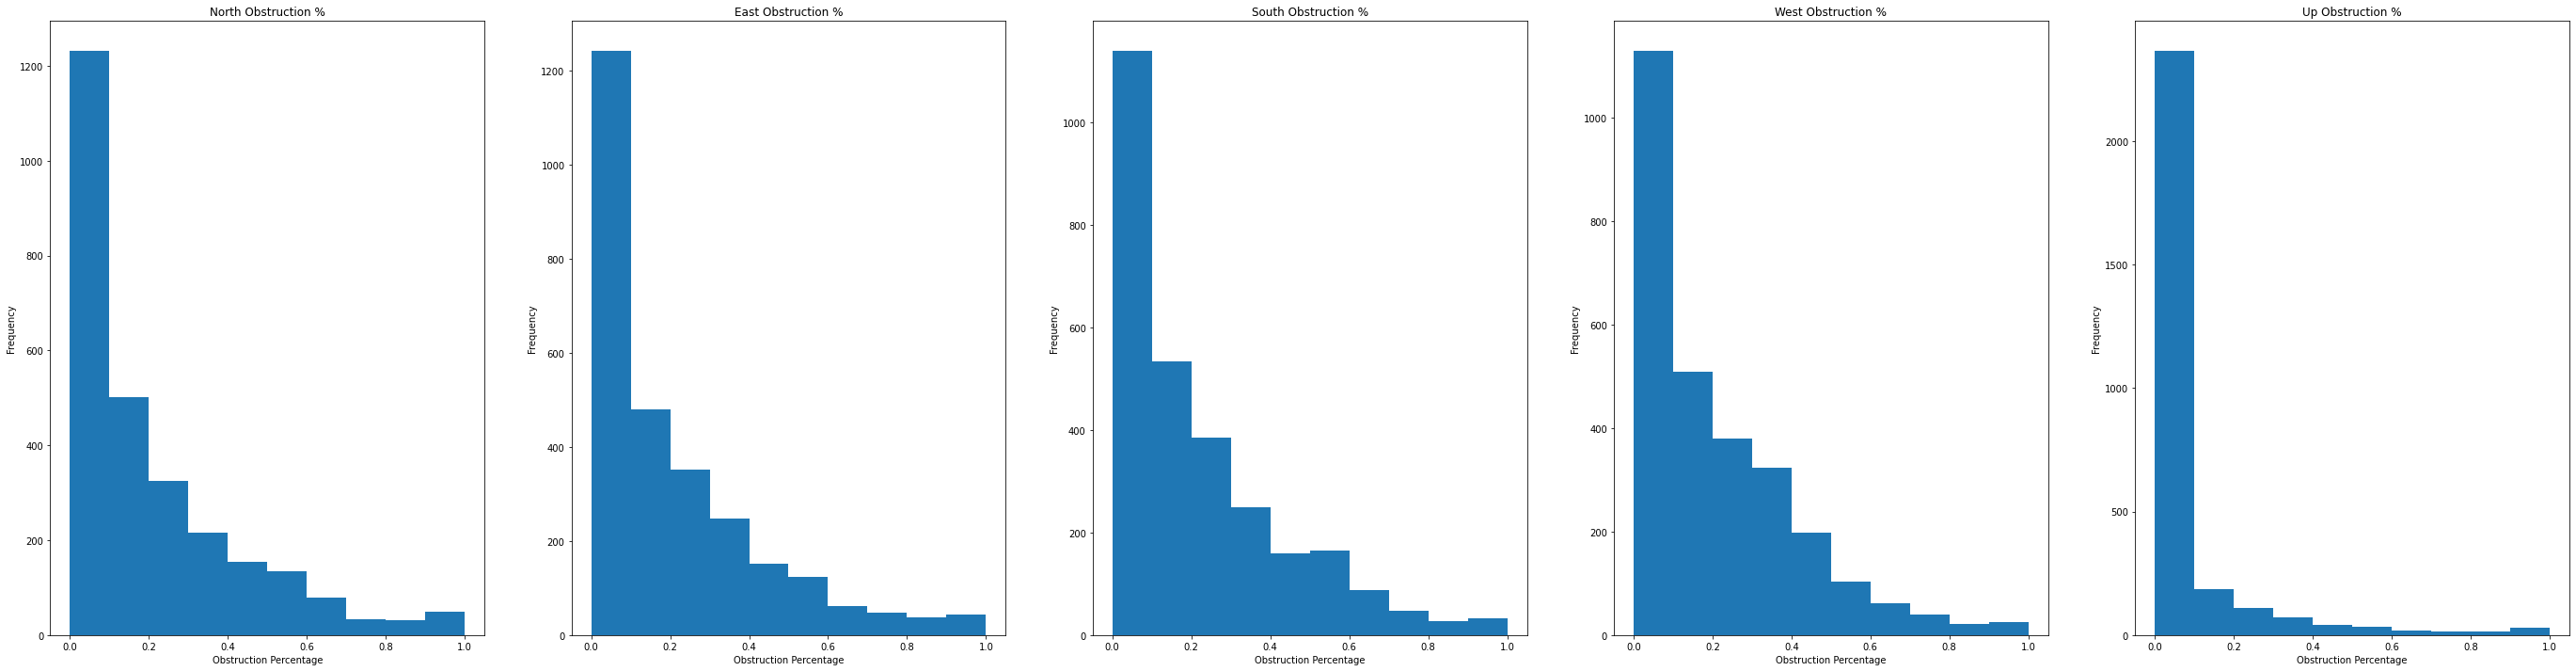

In [ ]:
titles = ['North Obstruction %', 'East Obstruction %', 'South Obstruction %', 'West Obstruction %', 'Up Obstruction %']
fig, axs = plt.subplots(1, 5, figsize=(48,12))

for i in range(0, 5, 1):
  vals = np.array(new_df.iloc[:,140+i])
  cleaned = vals[(vals != -1)]
  axs[i].hist(x=cleaned, bins=10)
  axs[i].set_title(titles[i])
  axs[i].set(xlabel='Obstruction Percentage', ylabel='Frequency')

Let's see if being GLOBE Trained and/or Citizen Science changes anything.

In [ ]:
g_and_cs = new_df[(new_df['Is GLOBE Trained'] == 1) & (new_df['is Citizen Science'] == 1)]
g_and_no_cs = new_df[(new_df['Is GLOBE Trained'] == 1) & (new_df['is Citizen Science'] == 0)]
no_g_and_cs = new_df[(new_df['Is GLOBE Trained'] == 0) & (new_df['is Citizen Science'] == 1)]

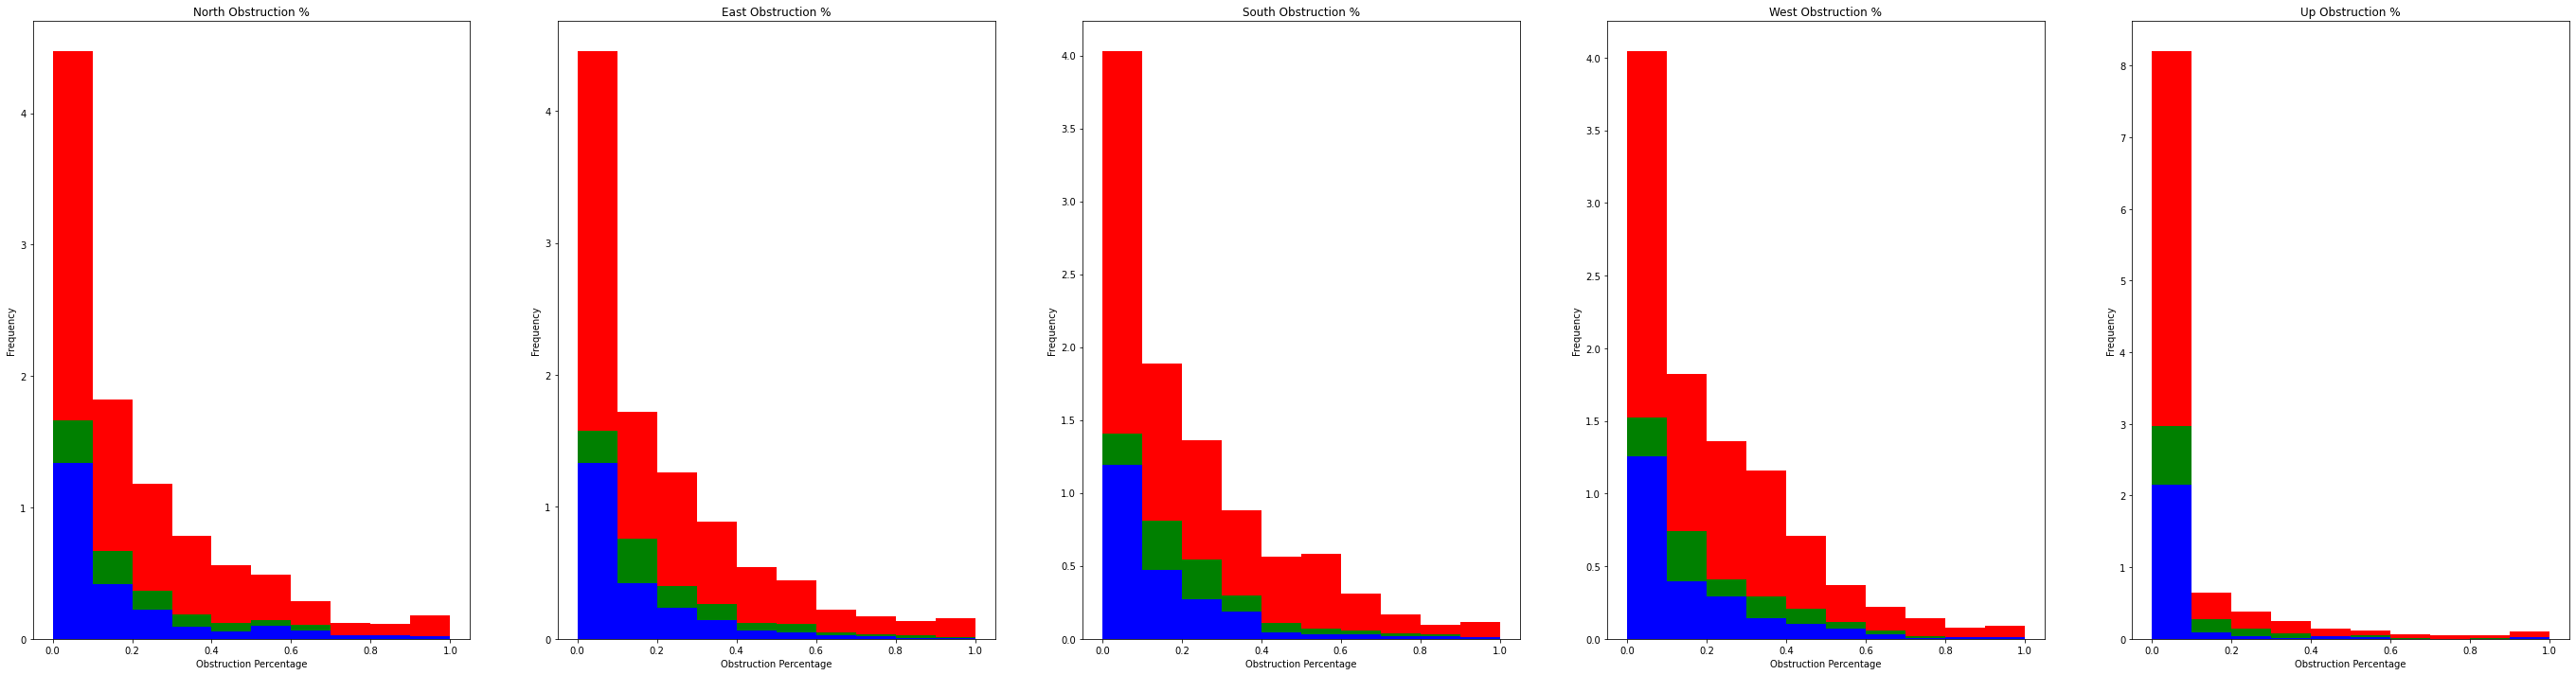

In [ ]:
titles = ['North Obstruction %', 'East Obstruction %', 'South Obstruction %', 'West Obstruction %', 'Up Obstruction %']
fig, axs = plt.subplots(1, 5, figsize=(48,12))

for i in range(0, 5, 1):
  val1 = np.array(g_and_cs.iloc[:,140+i])
  val2 = np.array(g_and_no_cs.iloc[:,140+i])
  val3 = np.array(no_g_and_cs.iloc[:,140+i])

  cleaned1 = val1[(val1 != -1)]
  cleaned2 = val2[(val2 != -1)]
  cleaned3 = val3[(val3 != -1)]

  vals = [cleaned1, cleaned2, cleaned3]
  
  axs[i].hist(x=vals, bins=10, stacked=True, density=True, color=["blue", "green", "red"])
  axs[i].set_title(titles[i])
  axs[i].set(xlabel='Obstruction Percentage', ylabel='Frequency')

We can see that most of the entries are done by non-GLOBE trained, citizen scientists.